In [1]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import splitfolders
import pandas as pd
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import cv2
import numpy as np
from keras import preprocessing
from tensorflow.keras.utils import load_img
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [3]:
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [4]:
# Creating train,test and validation set and splitting them according to the ratio mentioned in the project guidelines.
input_folder = 'images/'
splitfolders.ratio(input_folder, output="dataset",
    seed=100, ratio=(.715, .16, .125), group_prefix=None)

Copying files: 1176 files [00:15, 74.88 files/s]


In [ ]:
# ls = []
# for files in glob.glob('/content/drive/My Drive/Colab Notebooks/dataset/**/*.jpg',recursive = True): 
#   # print(files)
#   a = load_img(files)
#   dt_test = tf.keras.utils.image_dataset_from_directory(
#     '/content/drive/My Drive/Colab Notebooks/dataset/test',
#     labels='inferred',
#     label_mode = 'categorical',
#     image_size=(224, 224),
#     shuffle=False)
#   dt_train = tf.keras.utils.image_dataset_from_directory(
#     '/content/drive/My Drive/Colab Notebooks/dataset/train',
#     labels='inferred',
#     label_mode = 'categorical',
#     image_size=(224, 224),
#     shuffle=True)
#   dt_validation = tf.keras.utils.image_dataset_from_directory(
#     '/content/drive/My Drive/Colab Notebooks/dataset/val',
#     labels='inferred',
#     label_mode = 'categorical',
#     image_size=(224, 224),
#     shuffle=False)
#   ls.append(a)

In [5]:
# Loading images from the train,test and validation datasets created earlier.
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/My Drive/Colab Notebooks/dataset/train',
  seed=123,
  image_size=(224, 224),
  batch_size = 5,
  labels='inferred',
  label_mode = 'categorical',
  shuffle = True)
test_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/My Drive/Colab Notebooks/dataset/test',
  seed=123,
  image_size=(224, 224),
  batch_size = 5,
  labels='inferred',
  label_mode = 'categorical',
  shuffle = False)
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/My Drive/Colab Notebooks/dataset/val',
  seed=123,
  image_size=(224, 224),
  batch_size = 5,
  labels='inferred',
  label_mode = 'categorical',
  shuffle = False)

Found 827 files belonging to 20 classes.
Found 171 files belonging to 20 classes.
Found 178 files belonging to 20 classes.


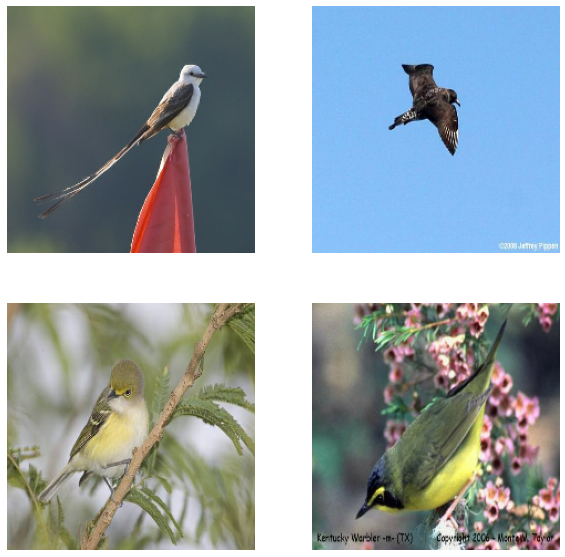

In [6]:
# Visualizing Images after resizing 
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [7]:
# Custom function has been sourced from an online resource mentioned in the references.

def custom_augmentation(np_tensor):
 
  def random_crop(np_tensor):
 
    new_height = int(np.random.uniform(0.7, 1.30) * np_tensor.shape[0])
    new_width = int(np.random.uniform(0.7, 1.30) * np_tensor.shape[1])
    cropped = tf.image.resize_with_crop_or_pad(np_tensor, new_height, new_width)
 
    return tf.image.resize(cropped, np_tensor.shape[:2])
 
  augmnted_tensor = random_crop(np_tensor)
  return np.array(augmnted_tensor)

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.8],
                                     width_shift_range=0.3, 
                                     height_shift_range=0.2,
                                     zoom_range = 0.33,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     preprocessing_function = custom_augmentation) 

# Did not perform resizing and rescaling as the pretrained models take care of it in their preprocessing steps.

In [8]:
valtest_generator_vgg = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing for validation and testing set

train_generator_vgg = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.3,0.5],
                                     width_shift_range=0.3, 
                                     height_shift_range=0.2,
                                     zoom_range = 0.33,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     preprocessing_function = preprocess_input) # VGG16 preprocessing for training set


traingen_vgg = train_generator_vgg.flow_from_directory('/content/drive/My Drive/Colab Notebooks/dataset/train',
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               batch_size=5, 
                                               shuffle=True,
                                               seed=30)

valgen_vgg = valtest_generator_vgg.flow_from_directory('/content/drive/My Drive/Colab Notebooks/dataset/val',
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               batch_size = 5,
                                               shuffle = True,
                                               seed = 30)

testgen_vgg = valtest_generator_vgg.flow_from_directory('/content/drive/My Drive/Colab Notebooks/dataset/test',
                                             target_size = (224, 224),
                                             class_mode = 'categorical',
                                             batch_size = 5,
                                             shuffle=False,
                                             seed = 30)

Found 827 images belonging to 20 classes.
Found 178 images belonging to 20 classes.
Found 171 images belonging to 20 classes.


In [ ]:
#Crop,zoom,rotate,flip,contrast and translate

# resize_and_rescale = tf.keras.Sequential([
#   layers.Resizing(224, 224),
#   layers.Rescaling(1./255)
# ]) 

# data_augmentation = keras.Sequential(
#   [
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.45),
#     layers.RandomZoom(0.33),
#     layers.RandomContrast(factor=(0.1,0.8)),
#     layers.RandomTranslation(height_factor= 0.3,width_factor=0.2,fill_mode='reflect'),
#     layers.RandomCrop(200,180)
      
#   ]
# )

# Visualizing Images after apllying data augmentation techniques 
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(4):
#     ax = plt.subplot(2, 2, i+1)
#     aug_img = data_augmentation(images)
#     plt.imshow(aug_img[0].numpy().astype("uint8")) # Augmentation applied on the same image.
#     plt.axis("off")

(-0.5, 223.5, 223.5, -0.5)

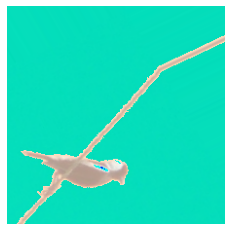

In [9]:
#Crop,zoom,rotate,flip,contrast and translate

# Contrast and Cropping were causing problems as they were leading to low accuraccy so performed augmentation repeatedely to find a good estimate for parameters by trial and error.

# Visualizing Images after apllying data augmentation techniques 

plt.imshow(traingen_vgg.next()[0][0].astype('uint8'))
plt.axis('off')

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16,EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalMaxPool2D,Dense,Dropout,BatchNormalization
from tensorflow.keras import Input

In [11]:
from keras.engine.sequential import Sequential
# vgg16, globalmaxpooling, dense(20,relu), batch-normalization, dropout, dense(softmax) --> Globalmaxpooling ki jagah flatten bhi try karo.
# input_top = False in vgg16

# Importing VGG16 Model
vgg16_model = VGG16(weights = 'imagenet',include_top = False,input_shape=(224,224,3)) 

# Freezing the layers and removing the last layer from the pretrained VGG16 model.

model1 = Sequential()

for layer in vgg16_model.layers[:-1]: # Adding all layers except the last fully connected layer.
    model1.add(layer)    

for layer in model1.layers:
  layer.trainable = False # Freezing the layers.

# Transfer Learning 

# (vgg16_model.input, vgg16_model.layers[-1].output)

softmax_layer = layers.Softmax(20)

model2 = keras.Sequential(
  [ model1,
    GlobalMaxPool2D(), 
    Dense(512,activation='relu'), 
    BatchNormalization(),
    Dense(128,activation='relu'), # Added additional dense layer for improving accuraccy
    Dropout(0.2),
    Dense(20,activation='softmax') # 20 neurons 1 per class using the softmax activation function.
  ]
)
model2.build(input_shape=(None,224,224,3)) # Specifying the shape for the input layer.
# vgg16_model.summary() # Checking the architecture of VGG16.

In [ ]:
# Architecture of the model created by combinining the pretrained model and our custom layers added on top.
# model2.summary()

In [34]:
model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'] # 'categorical_accuracy'
)

# Learning Rate Scheduler

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

cbk = EarlyStopping(monitor='val_loss',patience = 10,verbose = 1,restore_best_weights = True,mode = "min") # Early Stopping 

filepath="weights-improvement-vgg16-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose = 0, save_best_only=True, mode='max') # Saving the parameters that have the lowest val_error or alternatively the highest val_acc


model2.fit_generator(traingen_vgg,epochs = 50,validation_data = valgen_vgg,verbose = 1,callbacks = [cbk,checkpoint],steps_per_epoch = 100)  

Epoch 1/50
100/100 [==============================] - 13s 126ms/step - loss: 1.0945 - accuracy: 0.6620 - val_loss: 1.1445 - val_accuracy: 0.7697
Epoch 2/50
100/100 [==============================] - 12s 119ms/step - loss: 1.0056 - accuracy: 0.6821 - val_loss: 1.3455 - val_accuracy: 0.7247
Epoch 3/50
100/100 [==============================] - 12s 121ms/step - loss: 1.0001 - accuracy: 0.6459 - val_loss: 1.8159 - val_accuracy: 0.7360
Epoch 4/50
100/100 [==============================] - 12s 124ms/step - loss: 0.9288 - accuracy: 0.7163 - val_loss: 1.6823 - val_accuracy: 0.7191
Epoch 5/50
100/100 [==============================] - 11s 114ms/step - loss: 0.9765 - accuracy: 0.6841 - val_loss: 1.6102 - val_accuracy: 0.7697
Epoch 6/50
100/100 [==============================] - 12s 116ms/step - loss: 1.0165 - accuracy: 0.6560 - val_loss: 1.9347 - val_accuracy: 0.7191
Epoch 7/50
100/100 [==============================] - 12s 116ms/step - loss: 0.9293 - accuracy: 0.6881 - val_loss: 1.5793 - val_ac

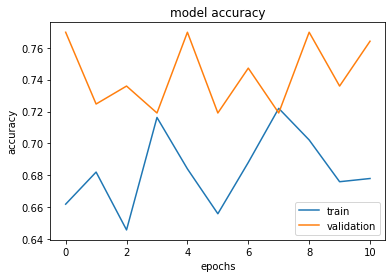

In [35]:
plt.plot(model2.history.history["accuracy"])
plt.plot(model2.history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["train", "validation"], loc="best")
plt.show()

In [14]:
from keras.applications import EfficientNetB0
from keras.applications.efficientnet import preprocess_input

In [15]:
valtest_generator_eff = ImageDataGenerator(preprocessing_function=preprocess_input) # EfficientNetB0 preprocessing for validation and testing set

train_generator_eff = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.3,0.5],
                                     width_shift_range=0.3, 
                                     height_shift_range=0.2,
                                     zoom_range = 0.33,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     preprocessing_function = preprocess_input) # EfficientNetB0 preprocessing for training set


traingen_eff = train_generator_eff.flow_from_directory('/content/drive/My Drive/Colab Notebooks/dataset/train',
                                               target_size = (224, 224),
                                               class_mode='categorical',
                                               batch_size = 5, 
                                               shuffle = True,
                                               seed = 30)

valgen_eff = valtest_generator_eff.flow_from_directory('/content/drive/My Drive/Colab Notebooks/dataset/val',
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               batch_size = 5,
                                               shuffle = True,
                                               seed = 30)

testgen_eff = valtest_generator_eff.flow_from_directory('/content/drive/My Drive/Colab Notebooks/dataset/test',
                                             target_size = (224, 224),
                                             class_mode = 'categorical',
                                             batch_size = 5,
                                             shuffle = False,
                                             seed = 30)

Found 827 images belonging to 20 classes.
Found 178 images belonging to 20 classes.
Found 171 images belonging to 20 classes.


In [17]:
from keras.engine.sequential import Sequential

# Importing EfficientNetB0 Model
eff_model = EfficientNetB0(weights = 'imagenet',include_top = False,input_tensor=Input((None,None, 3))) # Since we have Random Cropping applying a custom input_tensor so that the size is compatible for training.

# Freezing the layers and removing the last layer from the pretrained VGG16 model.

model3 = Sequential()
for layer in eff_model.layers[:-1]: # Adding all layers except the last fully connected layer.
  model3.add(layer)    

for layer in model3.layers:
  layer.trainable = False # Freezing the layers.

# # Transfer Learning 

In [27]:
model4 = keras.Sequential(
  [ eff_model,
    GlobalMaxPool2D(), 
    Dense(512,activation='relu'), 
    BatchNormalization(),
    Dense(128,activation='relu'), # Added additional dense layer for improving accuraccy
    Dropout(0.2),
    Dense(20,activation='softmax') # 20 neurons 1 per class using the softmax activation function.
  ]
)
model4.build(input_shape=(None,224,224,3)) # Specifying the shape for the input layer.

# eff_model.summary() # Checking the architecture of EfficientNetB0.

model4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'] 
)

# Learning Rate Scheduler

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=8000,
    decay_rate=0.75)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule) 

cbk = EarlyStopping(monitor='val_loss',patience = 10,verbose = 1,restore_best_weights = True,mode = "min") # Early Stopping 

filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max') # Saving the parameters that have the lowest val_error or alternatively the highest val_acc


model4.fit_generator(traingen_eff,epochs = 50,validation_data = valgen_eff,verbose = 1,callbacks = [cbk,checkpoint],steps_per_epoch = 100) 


Epoch 1/50
100/100 [==============================] - 46s 129ms/step - loss: 2.2778 - accuracy: 0.3119 - val_loss: 1.2523 - val_accuracy: 0.6180
Epoch 2/50
100/100 [==============================] - 11s 114ms/step - loss: 1.5073 - accuracy: 0.5453 - val_loss: 0.6845 - val_accuracy: 0.8258
Epoch 3/50
100/100 [==============================] - 11s 109ms/step - loss: 1.4575 - accuracy: 0.5473 - val_loss: 0.9680 - val_accuracy: 0.7135
Epoch 4/50
100/100 [==============================] - 11s 110ms/step - loss: 1.2691 - accuracy: 0.5920 - val_loss: 0.8896 - val_accuracy: 0.7191
Epoch 5/50
100/100 [==============================] - 11s 109ms/step - loss: 1.1970 - accuracy: 0.6217 - val_loss: 0.8093 - val_accuracy: 0.7360
Epoch 6/50
100/100 [==============================] - 11s 108ms/step - loss: 1.0936 - accuracy: 0.6700 - val_loss: 0.8623 - val_accuracy: 0.7640
Epoch 7/50
100/100 [==============================] - 12s 123ms/step - loss: 1.1201 - accuracy: 0.6700 - val_loss: 0.6057 - val_ac

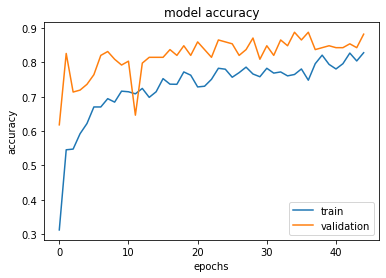

In [28]:
plt.plot(model4.history.history["accuracy"])
plt.plot(model4.history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["train", "validation"], loc="best")
plt.show()

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [36]:
y_true = testgen_vgg.classes
predictions = model2.predict(x=testgen_vgg, steps=len(testgen_vgg), verbose=0)
y_pred = predictions.argmax(axis=1)

print("VGG16 Precision, Recall and F1 Score --> ")
print("Precision : ",precision_score(y_true, y_pred, pos_label='positive',average='weighted'))
print("Recall : ",recall_score(y_true, y_pred, pos_label='positive',average='weighted'))
print("F1 : ",f1_score(y_true, y_pred, pos_label='positive',average='weighted'))
print("Accuracy : ",accuracy_score(y_true, y_pred))

VGG16 Precision, Recall and F1 Score --> 
Precision :  0.7813813040929746
Recall :  0.7426900584795322
F1 :  0.7257337136125632
Accuracy :  0.7426900584795322


In [32]:
y_true = testgen_eff.classes
predictions = model4.predict(x=testgen_eff, steps=len(testgen_eff), verbose=0)
y_pred = predictions.argmax(axis=1)

print("EfficientNetB0 Precision, Recall and F1 Score --> ")
print("Precision : ",precision_score(y_true, y_pred, pos_label='positive',average='weighted'))
print("Recall : ",recall_score(y_true, y_pred, pos_label='positive',average='weighted'))
print("F1 : ",f1_score(y_true, y_pred, pos_label='positive',average='weighted'))
print("Accuracy : ",accuracy_score(y_true, y_pred))

EfficientNetB0 Precision, Recall and F1 Score --> 
Precision :  0.8919044243605647
Recall :  0.8654970760233918
F1 :  0.8567006141553966
Accuracy :  0.8654970760233918


References :     
* https://pypi.org/project/split-folders/
* https://keras.io/examples/vision/learnable_resizer/
* https://stackoverflow.com/questions/14798220/how-can-i-search-sub-folders-using-glob-glob-module
* https://stackoverflow.com/questions/61702753/why-is-making-shuffle-false-on-validation-set-giving-better-results-in-confusion

* https://www.tensorflow.org/tutorials/images/data_augmentation
* https://dev.mrdbourke.com/tensorflow-deep-learning/04_transfer_learning_in_tensorflow_part_1_feature_extraction/
* https://keras.io/api/optimizers/
* https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/
* https://stackoverflow.com/questions/55335228/how-to-remove-the-last-layer-from-a-pre-trained-model-i-have-tried-model-layers
* https://keras.io/api/callbacks/early_stopping/
*  https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/ 
* https://datamonje.com/image-data-augmentation/







